<a href="https://colab.research.google.com/github/ijarin/Computer_Vision-Tensorflow-Keras-Practice/blob/main/Transfer_Learning_and_Fine_Tuning_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Setup
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
#Freezing layers, understanding the trainable attribute
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

All weights are trainable, only batch normalization has non trainable weights to keep track about mean and variance,  the BatchNormalization layer has 2 trainable weights and 2 non-trainable weights

In [ ]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


In [ ]:
#Freezing: Set trainable to False
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


When a trainable weights become Non-trainable, it's value is no longer updated during training

In [ ]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

layer1.trainable=False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - 0s 226ms/step - loss: 0.0618


If you set trainable = False on a model or on any layer that has sublayers, all children layers become non-trainable as well.

In [ ]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

Instantinate a base model with pre-trained weights

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

#Freeze the base model
base_model.trainable = False

#Create a new model on the top
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!ls

Transfer Learning and Fine tuning with custom training loop

In [ ]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

In [3]:
# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

Example of Fine tuning: Cats Vs. Dogs

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

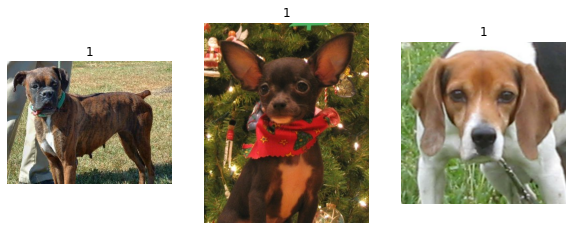

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(3)):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
#pre-processing: resize
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
#batch the data
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

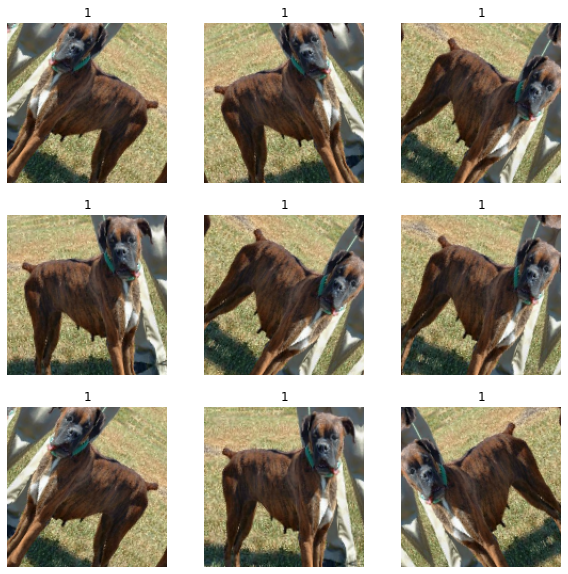

In [6]:
#random data augmentation
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

Build a model

In [7]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
______________________________________________________________

train the top layer, as we unfreez previous model

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fine Tuning entire model

In [9]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  